## Q2: Traffic Sign Detection

### Preparing Dataset

In [19]:
import requests, zipfile
from io import StringIO
import tensorflow as tf

In [ ]:
# do not run this unless you want to download and extract 1.5 gb of data
# this could take a while!
try:
    url="https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO(r.content))
    z.extractall("./data/FullIJCNN2013")
except:
    print("folder already exists!")

In [2]:
id_to_lable={0: "speed limit 20 (prohibitory)",
            1: "speed limit 30 (prohibitory)",
            2: "speed limit 50 (prohibitory)",
            3: "speed limit 60 (prohibitory)",
            4: "speed limit 70 (prohibitory)",
            5: "speed limit 80 (prohibitory)",
            6: "restriction ends 80 (other)",
            7: "speed limit 100 (prohibitory)",
            8: "speed limit 120 (prohibitory)",
            9: "no overtaking (prohibitory)",
            10: "no overtaking (trucks), (prohibitory)",
            11: "priority at next intersection (danger)",
            12: "priority road (other)",
            13: "give way (other)",
            14: "stop (other)",
            15: "no traffic both ways (prohibitory)",
            16: "no trucks (prohibitory)",
            17: "no entry (other)",
            18: "danger (danger)",
            19: "bend left (danger)",
            20: "bend right (danger)",
            21: "bend (danger)",
            22: "uneven road (danger)",
            23: "slippery road (danger)",
            24: "road narrows (danger)",
            25: "construction (danger)",
            26: "traffic signal (danger)",
            27: "pedestrian crossing (danger)",
            28: "school crossing (danger)",
            29: "cycles crossing (danger)",
            30: "snow (danger)",
            31: "animals (danger)",
            32: "restriction ends (other)",
            33: "go right (mandatory)",
            34: "go left (mandatory)",
            35: "go straight (mandatory)",
            36: "go right or straight (mandatory)",
            37: "go left or straight (mandatory)",
            38: "keep right (mandatory)",
            39: "keep left (mandatory)",
            40: "roundabout (mandatory)",
            41: "restriction ends (overtaking), (other)",
            42: "restriction ends (overtaking (trucks),), (other)"}

In [10]:
file= open("./data/FullIJCNN2013/gt.txt")
annotations={}
for f in file:
    line=f.split(';')
    if line[0] not in annotations.keys():
        annotations[line[0]]=[]
    annotations[line[0]].append([int(line[1]),int(line[2]),int(line[3]),int(line[4]),int(line[5])])

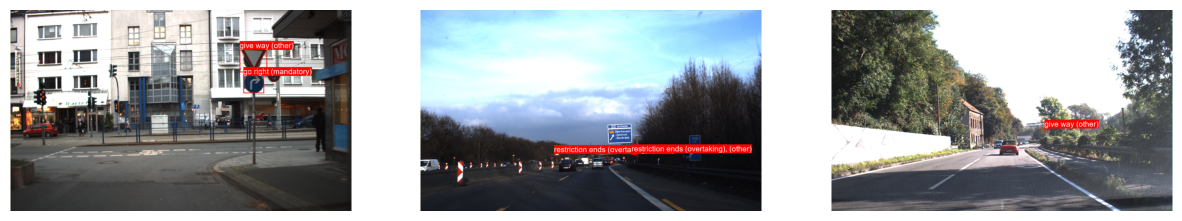

In [11]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random, os
import numpy as np

def load_and_convert_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".ppm"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            tensor_img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
            images.append(tensor_img)
    return images

images = load_and_convert_images("./data/FullIJCNN2013/")

def draw_annotations_on_image(img_idx, images, annotations):
    image = Image.fromarray((images[img_idx].numpy()).astype(np.uint8))
    draw = ImageDraw.Draw(image)

    if str(img_idx).zfill(5)+'.ppm' not in annotations.keys(): # no anotations
        return image
    
    for annotation in annotations[str(img_idx).zfill(5)+'.ppm']:
        rectangle_coords = (annotation[0], annotation[1], annotation[2], annotation[3])

        draw.rectangle(rectangle_coords, outline="red", width=3)

        text = id_to_lable[annotation[4]]
        text_position = (rectangle_coords[0], rectangle_coords[1] - 20) 
        font = ImageFont.truetype("arial.ttf", 30)
        _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
        background_coords = (text_position[0], text_position[1], text_position[0] + width, text_position[1] + height) 
        draw.rectangle(background_coords, fill="red")
        draw.text(text_position, text, fill="white", font=font)

    return image

num_images=3
random_selected = [draw_annotations_on_image(random.randint(0, len(images)), images, annotations) for _ in range(num_images)]

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for ax, img in zip(axes, random_selected):
    ax.imshow(img)
    ax.axis('off')

plt.show()
del images

In [12]:
size_label={0:'small',
               1: 'medium',
               2: 'large'}

def width_to_size_label(width):
    if width < 32:
        return size_label[0]
    elif width < 45:
        return size_label[1]
    return size_label[2]

In [13]:
size_label_count={'small':0, 'medium':0, 'large':0}
for v in annotations.values():
    for coords in v:
        size_label_count[width_to_size_label(np.abs(coords[0]-coords[2]))]+=1
print(size_label_count)

{'small': 413, 'medium': 366, 'large': 434}


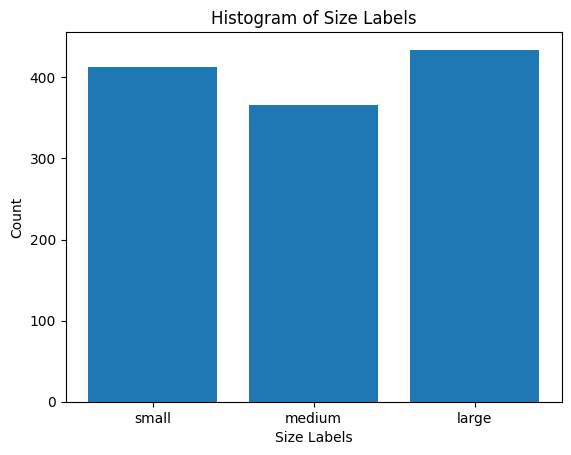

In [14]:
import matplotlib.pyplot as plt

labels = list(size_label_count.keys())
counts = list(size_label_count.values())

plt.bar(labels, counts)
plt.xlabel('Size Labels')
plt.ylabel('Count')
plt.title('Histogram of Size Labels')
plt.show()

In [15]:
labels_classified={'prohibitory':0, 'danger':0, 'mandatory':0, 'other':0}
for v in annotations.values():
    for coords in v:
        for label in labels_classified.keys():
            if (label in id_to_lable[coords[4]]): 
                labels_classified[label]+=1
print(labels_classified)

{'prohibitory': 557, 'danger': 219, 'mandatory': 163, 'other': 274}


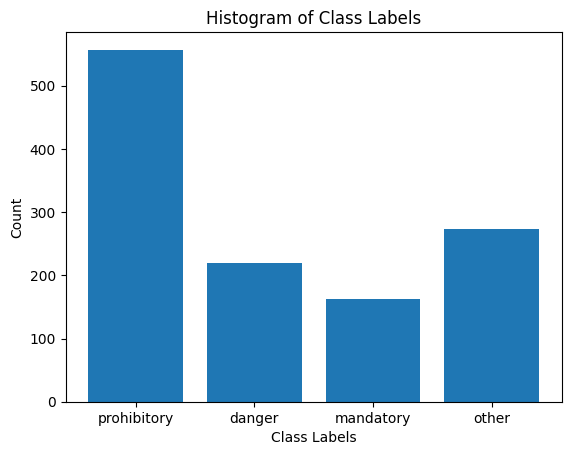

In [16]:
import matplotlib.pyplot as plt

labels = list(labels_classified.keys())
counts = list(labels_classified.values())

plt.bar(labels, counts)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Histogram of Class Labels')
plt.show()

In [17]:
test_indices = random.sample([i for i in annotations.keys()], int(len(annotations.keys())*0.2))
train_indices = list(set(i for i in annotations.keys())-set(test_indices))

In [21]:
from PIL import Image
import os
import numpy as np

def load_and_convert_images(directory, image_names):
    images = []
    for filename in os.listdir(directory):
        if filename in image_names:
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            tensor_img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
            images.append(tensor_img)
    return images

def get_image_tensors(image_names):
    images = load_and_convert_images("./data/FullIJCNN2013/", image_names)
    tf_dataset = tf.data.Dataset.from_tensor_slices(images)
    return tf_dataset

In [22]:
test_dataset=get_image_tensors(test_indices)

## 2 stage model

In [ ]:
import requests
import tarfile

url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz"
filename = url.split("/")[-1]

response = requests.get(url, stream=True)
with open('./models/'+filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

with tarfile.open('./models/'+filename, 'r:gz') as tar:
    tar.extractall()

In [25]:
import tensorflow as tf

saved_model_dir = './models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/saved_model/'

faster_rcnn_model = tf.saved_model.load(saved_model_dir)

In [4]:
import tensorflow as tf
import pandas as pd
import os
from object_detection.utils import dataset_util
from collections import namedtuple

def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_image_data = fid.read()
    width, height = 1280, 720

    filename = group.filename.encode('utf8')
    image_format = b'ppm'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for row in group.object.values:
        # print(row)
        # continue
        xmins.append(row[1] / width)
        xmaxs.append(row[2] / width)
        ymins.append(row[3] / height)
        ymaxs.append(row[4] / height)
        classes_text.append(id_to_lable[row[5]].encode('utf8'))
        classes.append(row[5])

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

csv_input = 'gt.csv'
output_path = './data/output.record'
image_dir = './data/FullIJCNN2013'

examples = pd.read_csv(csv_input)
grouped = split(examples, 'filename')
writer = tf.io.TFRecordWriter(output_path)

for group in grouped:
    tf_example = create_tf_example(group, image_dir)
    writer.write(tf_example.SerializeToString())

writer.close()
